In [3]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

from ntk import get_ntk_n
from linear_region_counter import Linear_Region_Collector

import scipy.stats as stats
import matplotlib.pyplot as plt

import tqdm

# custom
from custom_models import get_cell_based_tiny_net

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
# parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=0, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

8135
Namespace(arch_nas_dataset='../../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='../../configs/nas-benchmark/algos/RANDOM.config', data_path='../../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=8135, save_dir='./results/tmp', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=0)


In [5]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 8135
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 1
CUDA_VISIBLE_DEVICES : 1


In [9]:
def kaiming_normal_fanin_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def kaiming_normal_fanout_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def init_model(model, method='kaiming_norm_fanin'):
    if method == 'kaiming_norm_fanin':
        model.apply(kaiming_normal_fanin_init)
    elif method == 'kaiming_norm_fanout':
        model.apply(kaiming_normal_fanout_init)
    return model


def get_scores(xloader, network):
    device = torch.cuda.current_device()
    network.train()
    
    # generate random inputs
    inputs, _ = next(iter(xloader))
    inputs = inputs.cuda(device=device, non_blocking=True)
    inputs_ = torch.randn_like(inputs)
    
    # forward pass
    network.zero_grad(set_to_none=True)
    _, logits = network(inputs_)
    
    ################ fwrd pca score ################
    feat = network.last_feature_map.detach().clone()
    b,c,h,w = feat.size()
    feat = feat.permute(0,2,3,1).contiguous().view(b*h*w,c)
    m = feat.mean(dim=0, keepdim=True)
    feat = feat - m
    sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
    u, s, v = torch.svd(sigma)
    prob_s = s / s.sum()
    score = (-prob_s)*torch.log(prob_s+1e-8)
    score = score.sum()
    fwrd_pca_score = score.item()
    #################################################
    
    ################ fwrd norm score ################
    cell_features = network.cell_features
    scores = []
    for i in range(1, len(cell_features)):
        f_out = cell_features[i]
        f_in = cell_features[i-1]

        if (f_out.size() == f_in.size()) and (torch.all(f_in == f_out)):
            continue
#             scores.append(-np.inf)
        else:
            s1 = f_out.norm(p=2, dim=(1)).mean() / (f_in.norm(p=2, dim=(1)).mean()+1e-6)
            s2 = f_in.norm(p=2, dim=(1)).mean() / (f_out.norm(p=2, dim=(1)).mean()+1e-6)
#             s1 = f_in.abs().max() / (f_out.abs().max()+1e-6)
#             s2 = f_out.abs().max() / (f_in.abs().max()+1e-6)
            scores.append((-torch.abs(s1-1)).item() + (-torch.abs(s2-1)).item())
    fwrd_norm_score = np.mean(scores)
    #################################################
    
    ################ bkwd pca score ################
#     f_last = network.last_feature_map
    f_last = logits
    g = torch.ones_like(f_last)
#     g = torch.randn_like(f_last)
#     g = g / (g.norm(p=2, dim=(1),keepdim=True)+1e-6)
    f_last.backward(g, retain_graph=True)
    
    grad = network.first_feature_map.grad.detach().clone()
    b,c,h,w = grad.size()
    grad = grad.permute(0,2,3,1).contiguous().view(b*h*w,c)
    
    m = grad.mean(dim=0, keepdim=True)
    grad = grad - m
    sigma = torch.mm(grad.transpose(1,0),grad) / (grad.size(0))
    u, s, v = torch.svd(sigma)
    prob_s = s / s.sum()
    score = (-prob_s)*torch.log(prob_s+1e-8)
    score = score.sum()
    bkwd_pca_score = score.item()
    #################################################
    
    ################ bkwd norm score ################
    scores = []
    for i in reversed(range(1, len(cell_features))):
        f_out = cell_features[i]
        f_in = cell_features[i-1]

#         if (f_out.size() != f_in.size()): # only consider normal cells
#             continue
        if (f_out.size() == f_in.size()) and torch.all(f_in.grad == f_out.grad): # exclude identity cell
            continue
#             scores.append(-np.inf)
        else:
#             s1 = f_out.grad.norm(dim=(2,3)).mean() / (f_in.grad.norm(dim=(2,3)).mean()+1e-6)
#             s2 = f_in.grad.norm(dim=(2,3)).mean() / (f_out.grad.norm(dim=(2,3)).mean()+1e-6)
#             s1 = f_out.grad.norm(dim=(1)).mean() / (f_in.grad.norm(dim=(1)).mean()+1e-6)
#             s2 = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
            s1 = f_in.grad.abs().max() / (f_out.grad.abs().max()+1e-6)
            s2 = f_out.grad.abs().max() / (f_in.grad.abs().max()+1e-6)
#             s1 = f_in.grad.abs().max(dim=1)[0].mean() / (f_out.grad.abs().max(dim=1)[0].mean()+1e-6)
#             s2 = f_out.grad.abs().max(dim=1)[0].mean() / (f_in.grad.abs().max(dim=1)[0].mean()+1e-6)
#             s1 = f_in.grad.view(-1).abs().sum() / (f_out.grad.view(-1).abs().sum()+1e-6)
#             s2 = f_out.grad.view(-1).abs().sum() / (f_in.grad.view(-1).abs().sum()+1e-6)
#             s1 = f_out.grad.norm(p=2, dim=(1)).mean() / (f_in.grad.norm(p=2, dim=(1)).mean()+1e-6)
#             s2 = f_in.grad.norm(p=2, dim=(1)).mean() / (f_out.grad.norm(p=2, dim=(1)).mean()+1e-6)
#             s1 = f_out.grad.norm(p=1).mean() / (f_in.grad.norm(p=1).mean()+1e-6)
#             s2 = f_in.grad.norm(p=1).mean() / (f_out.grad.norm(p=1).mean()+1e-6)
            scores.append((-torch.abs(s1-1)).item() + (-torch.abs(s2-1)).item())
    
    
#             s_in = f_in.grad.norm(dim=(1)).mean() / (f_in.norm(dim=(1)).mean()+1e-6)
#             s_out = f_out.grad.norm(dim=(1)).mean() / (f_out.norm(dim=(1)).mean()+1e-6)
#             s_out = network.classifier.weight.grad.norm() / (network.classifier.weight.norm()+1e-6)
#             s_in = network.stem[0].weight.grad.norm() / (network.stem[0].weight.norm()+1e-6)
#             s1 = s_in / (s_out+1e-6)
#             s2 = s_out / (s_in+1e-6)
#             scores.append((-torch.abs(s1-1)).item() + (-torch.abs(s2-1)).item())
#             import matplotlib.pyplot as plt
#             plt.hist(f_in.grad.view(-1).cpu().numpy(), bins=100)
#             plt.hist(f_out.grad.view(-1).cpu().numpy(), bins=100)
#             plt.show()
#             print(s1, s2)
    bkwd_norm_score = np.mean(scores)
    #################################################
    
    return fwrd_pca_score, fwrd_norm_score, bkwd_pca_score, bkwd_norm_score


def search_find_best(xloader, network, criterion, lrc_model, n_samples):
    network.train()
    archs, fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores = [], [], [], [], []
    
    for i in tqdm.tqdm(range(n_samples)):
        # random sampling
        arch = network.random_genotype(True)
    
        fwrd_pca_score_tmp, fwrd_norm_score_tmp, bkwd_pca_score_tmp, bkwd_norm_score_tmp = [], [], [], []
        
        for _ in range(1):
            init_model(network)
            
            fwrd_pca_score, fwrd_norm_score, bkwd_pca_score, bkwd_norm_score = get_scores(xloader, network)
            
            fwrd_pca_score_tmp.append(fwrd_pca_score)
            fwrd_norm_score_tmp.append(fwrd_norm_score)
            bkwd_pca_score_tmp.append(bkwd_pca_score)
            bkwd_norm_score_tmp.append(bkwd_norm_score)
        
        archs.append(arch)
        fwrd_pca_scores.append(np.mean(fwrd_pca_score_tmp))
        fwrd_norm_scores.append(np.mean(fwrd_norm_score_tmp))
        bkwd_pca_scores.append(np.mean(bkwd_pca_score_tmp))
        bkwd_norm_scores.append(np.mean(bkwd_norm_score_tmp))
        
    fwrd_pca_scores = np.nan_to_num(np.array(fwrd_pca_scores), nan=-np.inf)
    fwrd_norm_scores = np.nan_to_num(np.array(fwrd_norm_scores), nan=-np.inf)
    bkwd_pca_scores = np.nan_to_num(np.array(bkwd_pca_scores), nan=-np.inf)
    bkwd_norm_scores = np.nan_to_num(np.array(bkwd_norm_scores), nan=-np.inf)
        
    return archs, fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores

def search_find_best_all(xloader, network, criterion, lrc_model, xargs):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    network.train()
    fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores = [], [], [], []
    all_time = []
    all_mem = []
    
    archs = generate_all_archs(network, xargs)
    
    for a in tqdm.tqdm(archs):
        # assign arch
        network.arch_cache = a
    
        fwrd_pca_score_tmp, fwrd_norm_score_tmp, bkwd_pca_score_tmp, bkwd_norm_score_tmp = [], [], [], []
        
        for _ in range(1):
            init_model(network)
            
            start.record()
            torch.cuda.reset_peak_memory_stats()
            fwrd_pca_score, fwrd_norm_score, bkwd_pca_score, bkwd_norm_score = get_scores(xloader, network)
            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
            all_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            
            fwrd_pca_score_tmp.append(fwrd_pca_score)
            fwrd_norm_score_tmp.append(fwrd_norm_score)
            bkwd_pca_score_tmp.append(bkwd_pca_score)
            bkwd_norm_score_tmp.append(bkwd_norm_score)
        
        fwrd_pca_scores.append(np.mean(fwrd_pca_score_tmp))
        fwrd_norm_scores.append(np.mean(fwrd_norm_score_tmp))
        bkwd_pca_scores.append(np.mean(bkwd_pca_score_tmp))
        bkwd_norm_scores.append(np.mean(bkwd_norm_score_tmp))
        
    fwrd_pca_scores = np.nan_to_num(np.array(fwrd_pca_scores), nan=-np.inf)
    fwrd_norm_scores = np.nan_to_num(np.array(fwrd_norm_scores), nan=-np.inf)
    bkwd_pca_scores = np.nan_to_num(np.array(bkwd_pca_scores), nan=-np.inf)
    bkwd_norm_scores = np.nan_to_num(np.array(bkwd_norm_scores), nan=-np.inf)
    
    print("------Runtime------")
    print("All: {:.5f} ms".format(np.mean(all_time)))
    print("------Avg Mem------")
    print("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
    print("------Max Mem------")
    print("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    return archs, fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores

def generate_all_archs(network, xargs):
    arch = network.random_genotype(True)
    
    search_space = get_search_spaces("cell", xargs.search_space_name)
    
    archs = arch.gen_all(search_space, xargs.max_nodes, False)
    
    return archs

# Main

In [7]:
## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))


## model
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

_, _, criterion = get_optim_scheduler(search_model.parameters(), config)
criterion = criterion.cuda()

if "api" not in vars():
    if xargs.arch_nas_dataset is None:
        api = None
    else:
        api = API(xargs.arch_nas_dataset, verbose=False)
    logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
# network = torch.nn.DataParallel(search_model).cuda()
network = search_model.cuda()

## LRC
if "lrc_model" not in vars():
    lrc_model = Linear_Region_Collector(input_size=(333, 3, 3, 3), sample_batch=3, dataset=xargs.dataset, data_path=xargs.data_path, seed=xargs.rand_seed)


## misc
if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
[2023-02-09 13:44:31] create API = NASBench201API(15625/15625 architectures, file=NAS-Bench-201-v1_1-096897.pth) done
Files already downloaded and verified
Files already downloaded and verified
=> do not find the last-info file : results/tmp/seed-8135-last-info.pth


In [50]:
n_samples = 200
archs, fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores = search_find_best(train_loader, network, criterion, lrc_model, n_samples)

# archs, fwrd_pca_scores, fwrd_norm_scores, bkwd_pca_scores, bkwd_norm_scores = search_find_best_all(train_loader, network, criterion, lrc_model, xargs)

100%|██████████| 200/200 [00:20<00:00,  9.57it/s]


In [51]:
def get_results_from_api(api, arch, dataset='cifar10'):
    dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
    assert dataset in dataset_candidates
    index = api.query_index_by_arch(arch)
    archresult = api.arch2infos_dict[index]['200']
    
    if dataset == 'cifar10-valid':
        acc = archresult.get_metrics(dataset, 'x-valid', iepoch=199, is_random=False)['accuracy']
    else:
        acc = archresult.get_metrics(dataset, 'ori-test', iepoch=199, is_random=False)['accuracy']
    flops = archresult.get_compute_costs(dataset)['flops']
    params = archresult.get_compute_costs(dataset)['params']
    
    return acc, flops, params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
#     valid_acc, flops, params = get_results_from_api(api, a, 'ImageNet16-120')
    valid_acc, flops, params = get_results_from_api(api, a, 'cifar10')
    api_valid_accs.append(valid_acc)
    api_flops.append(flops)
    api_params.append(params)

# Analysis

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|none~0|none~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|) with acc=67.83500000000001, fwd_pca_rank=56.0, fwrd_norm_rank=763.0, bkwd_pca_rank=678.0, bkwd_norm_rank=697.0, params_rank=1248.5, flops_rank=1248.5
15.64737 0.129306



|nor_conv_3x3~0|+|none~0|none~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3732
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=17.26 ms.
cifar10-valid  train : [loss = 0.006, top1 = 99.93%], valid : [loss = 0.498, top1 = 88.86%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=17.26 ms.
cifar10        train : [loss = 0.012, top1 = 99.78%], test  : [loss = 0.334, top1 = 92.08%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=16.76 ms.
cifar100       train : [loss = 0.327, top1 = 91.11%], valid : [loss = 1.246, top1 = 67.63%], test : [loss = 1.267, top1 = 68.04%]
Imag

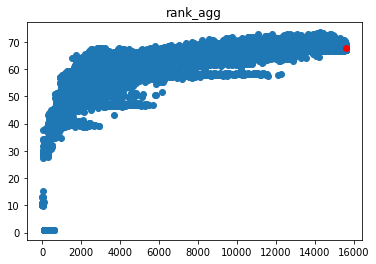

0.6839340986045118 0.0
aggregated: 0.6839340986045118
fwrd_pca: 0.5414736902754003
fwrd_norm: 0.6014470666282312
bkwd_pca: 0.5268545031432506
bkwd_norm: 0.3759026429829634
params: 0.5526807286799474


In [56]:
rank_fpca, rank_fnorm, rank_bpca, rank_bnorm, rank_flops, rank_params = \
stats.rankdata(fwrd_pca_scores), stats.rankdata(fwrd_norm_scores), stats.rankdata(bkwd_pca_scores), stats.rankdata(bkwd_norm_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

l = len(api_valid_accs)
# rank_agg = rank_params
# rank_agg = np.log(rank_bpca/l) + np.log(rank_bnorm/l)
rank_agg = np.log(rank_fpca/l) + np.log(rank_fnorm/l) + np.log(rank_bpca/l) + np.log(rank_bnorm/l) + np.log(rank_params/l)
# rank_agg = rank_fpca/l + rank_fnorm/l + rank_bpca/l + rank_bnorm/l + rank_params/l

best_idx = np.argmax(rank_agg)
best_arch, acc, best_rank_fpca, best_rank_fnorm, best_rank_bpca, best_rank_bnorm, best_rank_flops, best_rank_params = \
archs[best_idx], api_valid_accs[best_idx], rank_fpca[best_idx], rank_fnorm[best_idx], rank_bpca[best_idx], rank_bnorm[best_idx], rank_flops[best_idx], rank_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with acc={:}, fwd_pca_rank={:}, fwrd_norm_rank={:}, bkwd_pca_rank={:}, bkwd_norm_rank={:}, params_rank={:}, flops_rank={:}".format(
    best_arch, acc, l-best_rank_fpca, l-best_rank_fnorm, l-best_rank_bpca, l-best_rank_bnorm, l-best_rank_params, l-best_rank_flops))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
# x = bkwd_norm_scores
y = stats.rankdata(api_valid_accs)
y = api_valid_accs

plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=1)
# plt.xlim([-1,0])
# plt.xlim([12000,16000])
# plt.ylim([62,74])
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

#####
tau, p_value = stats.kendalltau(stats.rankdata(rank_agg), stats.rankdata(api_valid_accs))
print("aggregated: {}".format(tau))
tau, p_value = stats.kendalltau(stats.rankdata(rank_fpca), stats.rankdata(api_valid_accs))
print("fwrd_pca: {}".format(tau))
tau, p_value = stats.kendalltau(stats.rankdata(rank_fnorm), stats.rankdata(api_valid_accs))
print("fwrd_norm: {}".format(tau))
tau, p_value = stats.kendalltau(stats.rankdata(rank_bpca), stats.rankdata(api_valid_accs))
print("bkwd_pca: {}".format(tau))
tau, p_value = stats.kendalltau(stats.rankdata(rank_bnorm), stats.rankdata(api_valid_accs))
print("bkwd_norm: {}".format(tau))
tau, p_value = stats.kendalltau(stats.rankdata(rank_params), stats.rankdata(api_valid_accs))
print("params: {}".format(tau))

In [199]:
sorted_indices = np.argsort(api_valid_accs)
sorted_indices = np.argsort(bkwd_norm_scores)

for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(bkwd_norm_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):
    print(a)
    print("{:.3f}".format(acc), '\t', s)

[(('none', 0),) (('avg_pool_3x3', 0), ('skip_connect', 1))
 (('skip_connect', 0), ('nor_conv_3x3', 1), ('none', 2))]
58.293 	 -inf
[(('skip_connect', 0),) (('avg_pool_3x3', 0), ('skip_connect', 1))
 (('skip_connect', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
10.670 	 -2.529499730893544
[(('skip_connect', 0),) (('skip_connect', 0), ('skip_connect', 1))
 (('skip_connect', 0), ('none', 1), ('avg_pool_3x3', 2))]
33.775 	 -2.0944235750607083
[(('avg_pool_3x3', 0),) (('skip_connect', 0), ('nor_conv_1x1', 1))
 (('avg_pool_3x3', 0), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2))]
36.070 	 -2.08632521544184
[(('avg_pool_3x3', 0),) (('avg_pool_3x3', 0), ('skip_connect', 1))
 (('nor_conv_3x3', 0), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2))]
44.900 	 -2.066089825970786
[(('skip_connect', 0),) (('skip_connect', 0), ('none', 1))
 (('skip_connect', 0), ('avg_pool_3x3', 1), ('avg_pool_3x3', 2))]
34.140 	 -2.048802443913051
[(('skip_connect', 0),) (('skip_connect', 0), ('none', 1))
 (('nor_conv_3x3', 0)

<ipython-input-199-34f0cd32984c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(bkwd_norm_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):


In [55]:
# fp_results = torch.load("./c3n1_1000samples.pth")
# archs = fp_results['archs']
# fp_ntk_scores = fp_results['ntk_scores']
# fp_lr_scores = fp_results['lr_scores']
# api_valid_accs = fp_results['api_valid_accs']
# api_flops = fp_results['api_flops']
# api_params = fp_results['api_params']

# torch.save({"archs":archs,
#             "fwrd_pca_scores":fwrd_pca_scores,
#             "fwrd_norm_scores":fwrd_norm_scores,
#             "bkwd_pca_scores":bkwd_pca_scores,
#             "bkwd_norm_scores":bkwd_norm_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./4metrics_all_archs.pth")

trained_results = torch.load("./4metrics_all_archs.pth")
archs = trained_results['archs']
fwrd_pca_scores = trained_results['fwrd_pca_scores']
fwrd_norm_scores = trained_results['fwrd_norm_scores']
bkwd_pca_scores = trained_results['bkwd_pca_scores']
bkwd_norm_scores = trained_results['bkwd_norm_scores']
api_valid_accs = trained_results['api_valid_accs']
api_flops = trained_results['api_flops']
api_params = trained_results['api_params']